# 통계까지 논리 전개

In [2]:
# 데이터 처리 및 분석
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import warnings

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

# 출력 설정
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# 한글 폰트 설정
import platform
if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
elif platform.system() == 'Darwin':  # macOS
    plt.rcParams['font.family'] = 'AppleGothic'
else:  # Linux
    plt.rcParams['font.family'] = 'NanumGothic'

plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (12, 6)

# 시드 설정
np.random.seed(42) # 팀원간의 결과물이 동일하게 보일 수 있음

print("="*60)
print("라이브러리 로드 완료!")
print("한글 폰트 설정 완료!")

라이브러리 로드 완료!
한글 폰트 설정 완료!


고객 만족도는 구매와 연결되는 중요한 요인입니다. 따라서 고객 만족도를 최대한 개선하거나, 높은 고객 만족도를 얻을 만한 상품을 고객에게 제안해여 합니다. 먼저 고객 만족 개선을 위해 긍정, 중립, 부정으로 나누고 리뷰의 워드 클라우드를 구성하여 고객의 불만족 요인을 분석하였습니다. 그 결과 부정 집단에서 배송과 관련된 부정 의견이 상당수 등장하는 것을 확인할 수 있었습니다.

# 통계

### 함수 로드

전처리 함수

In [3]:
def date_diff(start_date, end_date):
    date_diff = pd.to_datetime(end_date) - pd.to_datetime(start_date)
    return date_diff.days

def to_date(data ,column_list):
    for column in column_list:
        data[column] = pd.to_datetime(data[column])
    return data

def handle_outliers_iqr_num(df):
    # 수치형 컬럼만 선택
    numeric_cols = df.select_dtypes(include='number').columns
    df_out = df.copy()


    for col in numeric_cols:
        Q1 = df_out[col].quantile(0.25)
        Q3 = df_out[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # 이상치를 하한선 또는 상한선으로 대체
        df_out = df_out[(df_out[col] > lower_bound) & (df_out[col] < upper_bound)]

    return df_out

def handle_outliers_iqr_selection(df, columns):
    df_out = df.copy()

    for col in columns:
        Q1 = df_out[col].quantile(0.25)
        Q3 = df_out[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # 이상치를 하한선 또는 상한선으로 대체
        df_out = df_out[(df_out[col] > lower_bound) & (df_out[col] < upper_bound)]

    return df_out

In [4]:
import os
os.chdir(r"C:\Users\lizzy\스파르타_파이썬\심화플젝")
print(os.getcwd())  # 잘 바뀌었는지 확인

C:\Users\lizzy\스파르타_파이썬\심화플젝


(지연) 이상치 제거 함수가 중복된 듯한데, 일부러 두 가지 방식(모든 수치형vs사용자 지정 컬럼만)으로 구분하신 건가요?
-> 해당 함수는 전처리 단계에서 쓰지 않기로 했고, 통계분석할 때 잠깐 쓰기로 했어서, 컬럼 지정 버전(두 번째 함수)만 쓰면 될 것 같은데, 어떠신가요?

(지연) to_date 관련 함수 둘 다 쓰시나요? 뒤에서 쓰는 것만 남기면 좋을 듯하고, 둘 다 쓴다면 논리상 to_date 함수를 먼저, 그 다음에 date_diff로 순서 바꾸는 게 좋을 듯합니다.

통계 함수

In [5]:
def levene_stat(df, label_column, target_column):
  labels = df[label_column].unique()
  df_split = []
  result = ''
  for label in labels:
    df_split.append(df[df[label_column] == label][target_column])

  stat, p = stats.levene(*df_split)

  if p < 0.05:
    result = '귀무가설을 기각'
  else:
    result = '귀무가설을 기각하지 않음'

  print(f"""
  ==================================
  등분산 검정 결과
  ==================================
  p-value: {p:3f}
  ==================================
  {result}
  ==================================
  """)

def shapiro_stat(df, label_column, target_column):
  labels = df[label_column].unique()
  p_results = []
  result = ''
  for label in labels:
    p, stat = stats.shapiro(df[df[label_column] == label][target_column])
    p_results.append(p)

  if all(p > 0.05 for p in p_results):
    result = '모든 집단의 분포가 정규 분포임'
  else:
    result = '정규 분포가 아닌 집단이 존재함'

  print(f"""
  ==================================
  정규성 검정 결과
  ==================================
  {result}
  ==================================
  """)

(지연) 논리상 정규성이 먼저, 등분산성이 다음에 오면 좋을 듯합니다

### 파일 로드 및 처리

#### 주문 데이터

(지연) 해당 소제목을 이렇게 바꾸면 어떨까요 -> 예상과 실제 배송 소요 일수 차이 계산


In [6]:
olist_orders_dataset = pd.read_csv("olist_orders_dataset.csv")

In [7]:
date_column_list = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']
olist_orders_dataset = to_date(olist_orders_dataset, date_column_list)

In [8]:
# 실제 주문 날짜와 '예상' 배송 날짜 차이
olist_orders_dataset['estimated_dt'] = olist_orders_dataset.apply(
    lambda row: date_diff(
        row['order_purchase_timestamp'],
        row['order_estimated_delivery_date']
    ),
    axis=1  # 행 단위 적용 (필수)
)

# 실제 주문 날짜와 '실제' 배송 날짜 차이
olist_orders_dataset['real_dt'] = olist_orders_dataset.apply(
    lambda row: date_diff(
        row['order_purchase_timestamp'],
        row['order_delivered_customer_date']
    ),
    axis=1
)

# 실제 주문 날짜와 판매자가 배송 시작한 날짜 차이
olist_orders_dataset['seller_dt'] = olist_orders_dataset.apply(
    lambda row: date_diff(
        row['order_purchase_timestamp'],
        row['order_delivered_carrier_date']
    ),
    axis=1  # 행 단위 적용 (필수)
)

In [9]:
# IQR 통계 기반으로 이상치 제거
olist_orders_dataset = handle_outliers_iqr_num(olist_orders_dataset)

In [10]:
# 결측값이 있는 행을 전체 데이터셋에서 즉시 삭제
olist_orders_dataset.dropna(inplace=True)

In [11]:
# 예상 배송 일수와 실제 배송 일수 간의 차이 컬럼 생성
olist_orders_dataset['dd'] = olist_orders_dataset['estimated_dt'] - olist_orders_dataset['real_dt']

(지연) 주석 추가 (내용 맞나요?)

(지연) 새 컬럼 'dd'(예상 배송 일수와 실제 배송 일수 간의 차이)는 중요하므로, 이해하기 쉽게 더 설명적인 컬럼명으로 바꾸면 어떨까요? -> delivery_date_diff 등

#### 리뷰 데이터 처리

In [12]:
olist_order_reviews_dataset = pd.read_csv("olist_order_reviews_dataset.csv")

In [13]:
# 리뷰 평점을 새로운 스코어로 변환 (나쁜·보통(1~3점) 리뷰는 0, 좋은(4~5점) 리뷰는 1로 이진 분류)
olist_order_reviews_dataset['new_score'] = olist_order_reviews_dataset['review_score'].map({1:0, 2:0, 3:0, 4:1, 5:1})

(지연) 리뷰 분석 시 평점 3점은 '중립'으로 두기로 하지 않았었나요?

olist_order_reviews_dataset_new ['order_id', 'new_score', 'review_score']

In [14]:
# 새로운 데이터프레임 생성 및 중복 제거 (주문 번호, 변환된 평점, 원래 평점 컬럼만)
olist_order_reviews_dataset_new = olist_order_reviews_dataset[['order_id', 'new_score', 'review_score']]
olist_order_reviews_dataset_new = olist_order_reviews_dataset.drop_duplicates()

(지연) 주석 추가 (내용 맞나요?)

(지연) 편의상 새로운 df명을 더 짧고, 통일감 있게 'df_order_reviews_new' 정도로 해도 좋을 것 같습니다.

(지연) 평점 맵핑 새로 하면서 제거할 중복 데이터가 생겼던가요? (제가 뭘 놓친 걸까요?ㅠㅠ)

#### 상품 데이터 처리

(지연) '상품 데이터 처리' 보다는 '주문 항목 데이터 처리'가 맞을 듯합니다

In [15]:
olist_order_items_dataset = pd.read_csv("olist_order_items_dataset.csv")

In [16]:
# 주문 항목 테이블에서 주문번호와 상품번호만 남기기 (각 주문이 어떤 상품으로 구성되어 있는지를 보기 위해)
olist_order_items_dataset = olist_order_items_dataset[['order_id', 'product_id']]

(지연) 주석 추가 (내용 맞나요?)

## 배송과 만족도의 상관관계

먼저 리뷰점수를 고객 만족도의 지표로 삼아 배송 기간에 따라 고객 만족도의 차이가 있는지 확인하였다. 배송이 부정적 만족도를 유도한다면, 늦은 배송이 낮은 만족도를 유도할 것이라 예상할 수 있기 때문이다. 따라서 주문 데이터 셋과 리뷰 데이터 셋 중 어떤 데이터도 누락되면 안되기 때문에 이너 조인을 통해 테이블을 결합하여 상관관계를 계산하였다.

In [17]:
df = pd.merge(olist_orders_dataset, olist_order_reviews_dataset_new, on='order_id', how='inner')

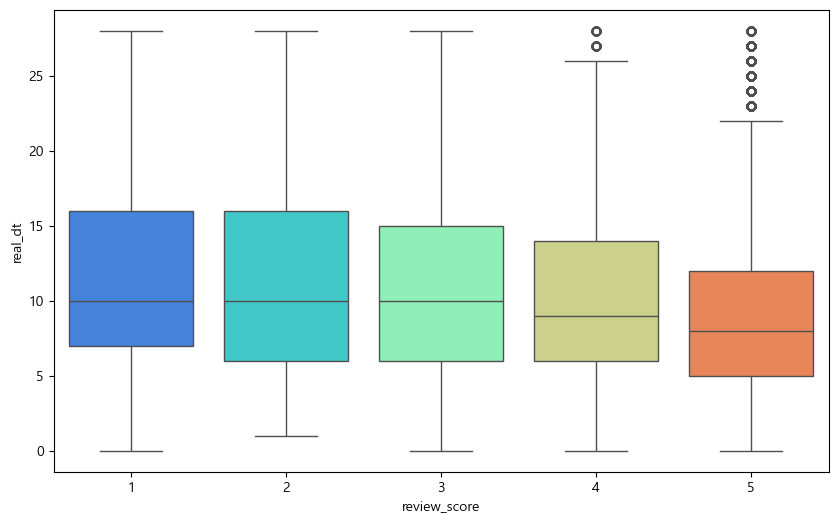

In [18]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='review_score', y='real_dt', palette='rainbow')
plt.show()

실제 주문 날짜와 '실제' 배송 날짜 차이

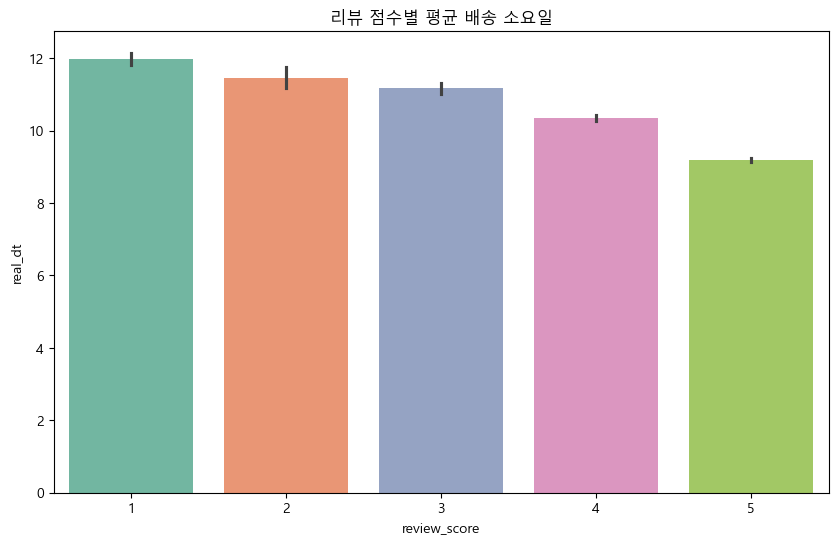

In [32]:
plt.figure(figsize=(10, 6))
plt.title('리뷰 점수별 평균 배송 소요일')
sns.barplot(data=df, x='review_score', y='real_dt', palette='Set2')
plt.show()

(지연) 위 두 셀 중복인 듯해 하나 삭제하면 될 듯합니다.

시각적으로 확인하면 리뷰 점수가 낮은 집단에서 평균 배송 기간이 길어지는 것을 확인할 수 있습니다. 일종의 선형적 관계가 있다고도 볼 수 있습니다. 이를 정확하게 확인하기 위해 통계적 분석을 시행하여 통계적 차이가 있는지 확인하였습니다.

In [20]:
from scipy import stats
import pingouin as pg


levene_stat(df, 'review_score', 'real_dt')
shapiro_stat(df, 'review_score', 'real_dt')


welch_result = pg.welch_anova(dv='real_dt', between='review_score', data = df)
print(f"""
  ==================================
  Welch's ANOVA 결과
  ==================================
  p-value: {welch_result['p-unc'].item():3f}
  ==================================
  {('검정 결과가 통계적으로 유의함'if welch_result['p-unc'].item() < 0.05 else '검정 결과가 통계적으로 유의하지 않음')}
  ==================================
  """)


  등분산 검정 결과
  p-value: 0.000000
  귀무가설을 기각
  

  정규성 검정 결과
  모든 집단의 분포가 정규 분포임
  

  Welch's ANOVA 결과
  p-value: 0.000000
  검정 결과가 통계적으로 유의함
  


(지연) 첫 두줄은 논리상 정규성이 먼저, 등분산성이 다음에 오면 좋을 듯합니다

검정 결과 리뷰 점수에 따라 배송 기간의 차이가 유의미하게 존재하고 있음을 확인하였습니다. 하지만 1점을 준 고객과 5점을 준 고객의 배송일 중앙값은 유사한 지점에서 형성되고 있음을 확인할 수 있어 이 결과가 마냥 선형적인 관계가 아닐 수 있다는 것을 일아낼 수도 있었습니다.

## 배송 예측의 부정확성

(지연) 여기서부터는 가설검증이니, 타이틀을 가설 관련 내용으로 가면 어떨까요? -> 가설설정: 배송 예측의 부정확성이 리뷰 점수의 저하로 이어질 수 있다

Olist 데이터 셋은 실제 배송 기간이 아닌 예상 배송기간 역시 제시해주고 있습니다. 여기서 배송 예측의 부정확성이 리뷰 점수의 저하로 이어질 수 있다는 가설을 세워보았습니다. 먼저 배송 예측이 부정확하다는 사실을 확인해 보았습니다.

estimated_dt    22.274237
real_dt          9.832643
dtype: float64


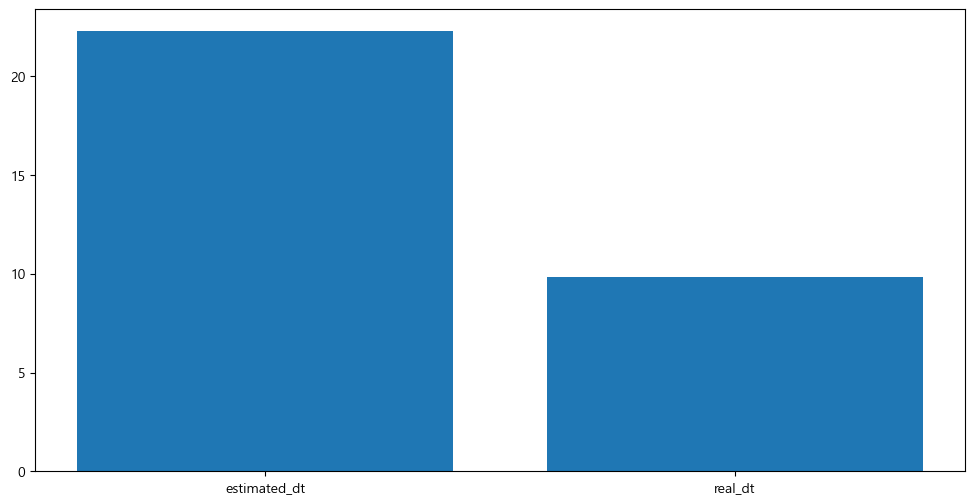

In [21]:
df_bar = df[['estimated_dt', 'real_dt']].mean()
print(df_bar)
plt.bar(df_bar.index, df_bar.values)
plt.show()

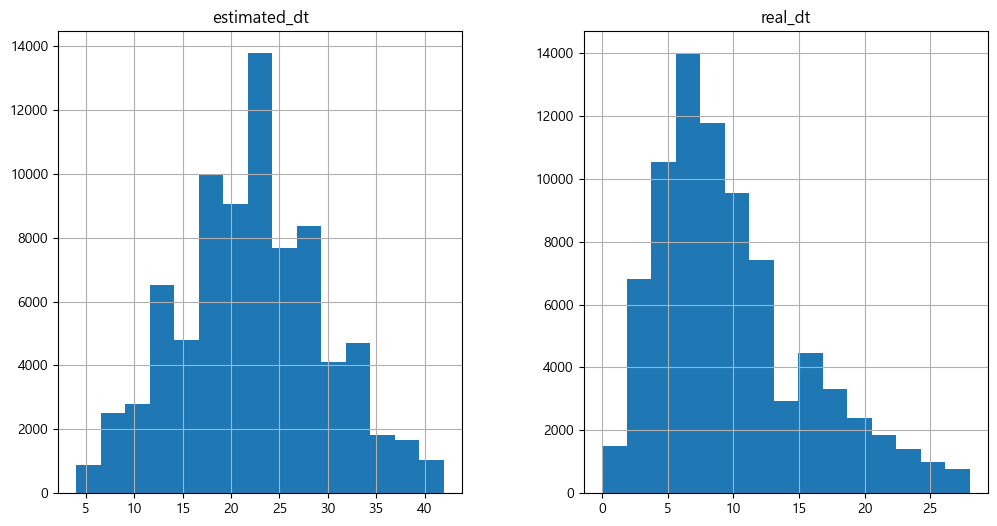

In [22]:
df[['estimated_dt', 'real_dt']].hist(bins = 15, figsize=(12, 6))
plt.show()

df['dd'] 예상 배송 일수와 실제 배송 일수 간의 차이

12.441594475831764


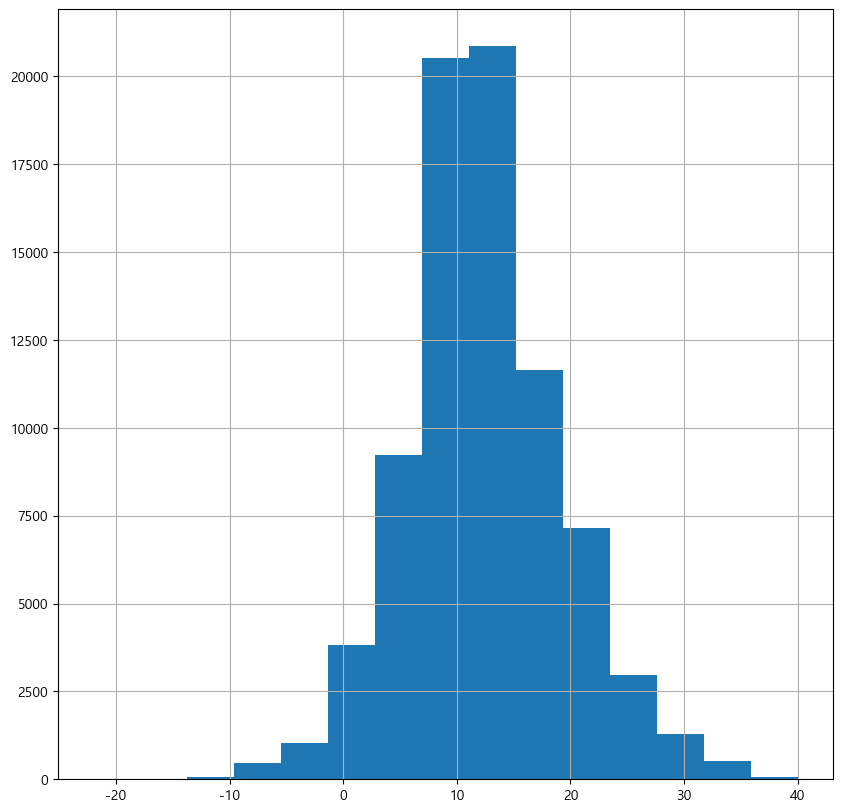

In [23]:
print(df['dd'].mean())
df['dd'].hist(bins = 15, figsize=(10, 10))
plt.show()

(지연) 위에서도 의견 드렸지만, 컬럼 'dd'(예상 배송 일수와 실제 배송 일수 간의 차이)는 중요하므로, 이해하기 쉽게 더 설명적인 컬럼명으로 바꾸면 어떨까요? -> delivery_date_diff 등

예측 모델은 데이터를 평균 22일을 기준으로 정규 분포에 가까운 분포를 보이는 반면, 실제 배송 시간은 평균 9일로 왼쪽으로 치우쳐진 긴꼬리 분포의 모양을 보입니다. 배송 예상 시간과 실제 배송시간의 차이는 12일 정도로 상당히 보수적으로 예측하고 있는 것을 확인 할 수 있었습니다. 문제는 배송 예측이 상당히 보수적으로 이루어지고 있음에도, 배송 지연이 발생하는 경우가 있었다는 것입니다. 이는 배송 예측 모델이 정확하지 않다는 사실을 설명한다고도 말할 수 있습니다.

(지연) 설명 처음에 '현재 예측 모델'이라고 짚어주면 좋을 듯합니다.

## 배송 지연에 따른 불만족

모델의 부정확성으로 인해 발생하는 지연으로 인해 어떤 문제가 발생할 수 있는지도 확인해 보았습니다.

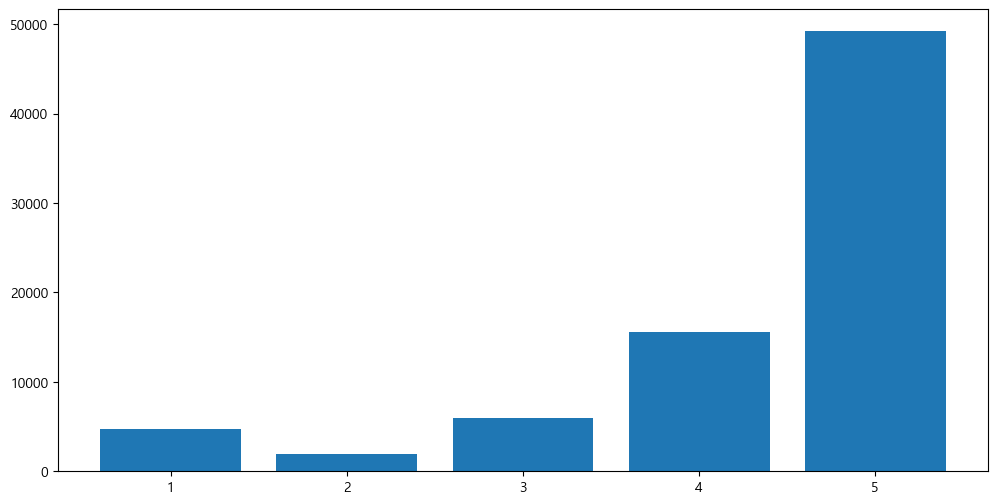

In [24]:
# 배송 예측이 실제보다 늦거나 같은 경우
df_2 = df[df['dd'] >= 0]
df_2_bar = df_2.groupby("review_score").size()
plt.bar(df_2_bar.index, df_2_bar.values)
plt.show()

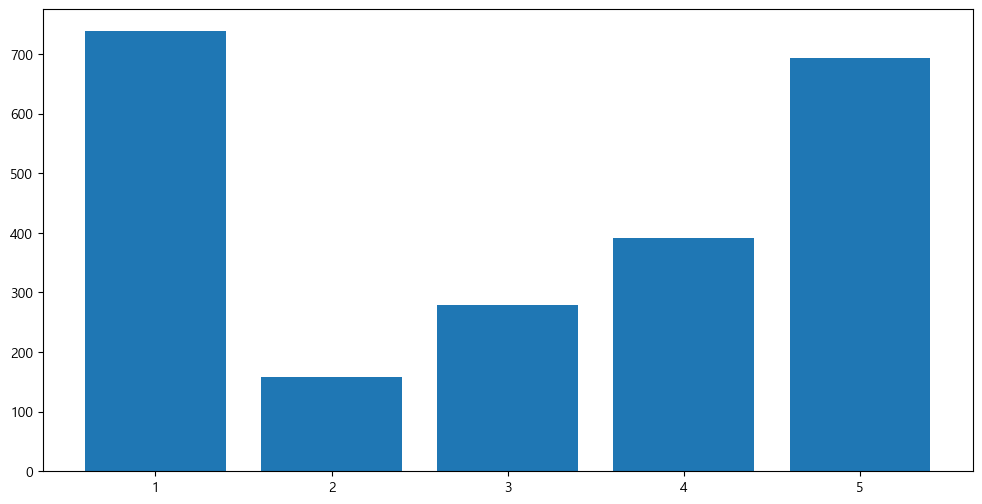

In [25]:
# 배송 예측이 실제보다 빨리 도착한 경우
df_1 = df[df['dd'] < 0]
df_1_bar = df_1.groupby("review_score").size()
plt.bar(df_1_bar.index, df_1_bar.values)
plt.show()

In [26]:
# 배송 지연 여부(배송시간 예측 실패 여부)를 이항변수(비지연: 0, 지연: 1)로 바꿔, 새로운 컬럼 생성
df['dd_g'] = 0 # 기본값을 0(비지연)으로 설정
df.loc[df['dd'] > 0, 'dd_g'] = 1 # 지연인 값만 1로 변경
df_crosstab = pd.crosstab(df['dd_g'], df['review_score']) # 배송 예측 실패 여부 vs 리뷰 점수 교차표 (카이제곱 교차표)
chi2, pval, dof, expected = stats.chi2_contingency(df_crosstab) # 두 변수 독립성(관계 있음/없음) 검정

print(f"""
  ==================================
  카이제곱 검정 결과
  ==================================
  p-value: {pval:2f}
  ==================================
  효과 크기: {np.sqrt(chi2 / len(df)):2f}
  ==================================
  {('검정 결과가 통계적으로 유의함'if pval < 0.05 else '검정 결과가 통계적으로 유의하지 않음')}
  ==================================
  """)


  카이제곱 검정 결과
  p-value: 0.000000
  효과 크기: 0.167184
  검정 결과가 통계적으로 유의함
  


(지연) 주석 추가 (내용 맞나요?)

(지연) Welch's ANOVA 결과가 맞나요? -> '카이제곱 검정 결과'로 수정해야 하는 거 아닌지요?

(지연) 새 컬럼 'dd_g'(배송 지연 여부)도 중요하므로, 이해하기 쉽게 더 설명적인 컬럼명으로 바꾸면 어떨까요? -> delivery_date_diff 등

효과 크기는 약한 효과만 존재한다고 설명하지만 시각화된 그래프에서 지연의 효과가 특히 1점 대에서 크게 나타나고 있음을 확인해주고 있습니다. 이는 배송 예측 시스템으로 인해 나타난 배송의 지연이 부정적 리뷰를 만들어 내는 원인이 될 수도 있다는 사실을 말해주고 있습니다.

# 결론

배송은 리뷰에 직간접적 영향을 주는 요인이라고 설명할 수 있습니다. 특히 배송의 지연은 리뷰에 부정적인 영향을 끼칠 가능성이 높습니다. 효과 크기가 낮다고 하더라도 1점 혹은 5점으로 편향된 리뷰가 나타날 수 밖에 없는 이커머스 환경에서 1점의 증가는 실질적인 부정 의견의 증가로도 볼 수 있기 때문입니다.

문제는 기존 배송 모델이 상당히 보수적으로 예측을 시행하고 있다는 데 있습니다. 예측 모델은 10일 정도 느리게 도착할 것이라 예측하고 있습니다. 그러나 보수적인 모델에서도 지연이 발생하고, 그로인해 불만족이 발생하고 있었습니다. 따라서 기존 모델의 정확도를 개선할 필요가 있음을 확인할 수 있습니다.

그러나 보수적 예측 자체가 가져오는 효용이 있다는 것 역시 확인할 수 있었습니다. 기존 모델이 보수적 예측을 통해 부정확한 예측에서 오는 지연을 방지하였고, 동시에 기존 예측보다 일찍 도착하는 결과를 통하여 고객의 만족을 유도한 것입니다. 따라서 모델을 구성한다면, 정확한 예측 모델을 구성하되 실제 출력에서 예상 시간 혹은 날짜를 더하는 등, 보수적 예측을 하도록하는 것이 더 좋을 것입니다.